# Computational and Variational Methods for Inverse Problems

## Assignment 2: Optimization methods and automatic differentiation

### (Notebook outline for problems 2, 3, and 4)

### Your name:
Ziheng Chen (zc5282)

## Dependencies:

 - numpy
 - scipy
 - matplotlib
 - autograd (https://github.com/HIPS/autograd)

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from scipy import optimize
from tqdm import tqdm

# 2) Discretized length and energy functionals

In this problem you will write code to compute the length functional $L(u)$ and energy functional $E(u)$ from problem 1, for continuous piecewise linear functions $u:[0,1]\rightarrow \mathbb{R}$ with equally spaced nodes. We assume that $u$ has $N+2$ equally spaced nodes at locations
$$0, h, 2h, 3h, \dots, Nh, 1$$
and that $u$ takes specified values at the nodes, and is piecewise linear in the intervals ("cells") between these nodes.

## 2a) Spatial derivative of piecewise linear function
Let $u(x)$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes (including endpoints). The spatial derivative $\frac{du}{dx}$ is piecewise constant on the $N+1$ cells between neighboring nodes. An example of this is shown below.

Text(0.5, 1.0, 'du/dx')

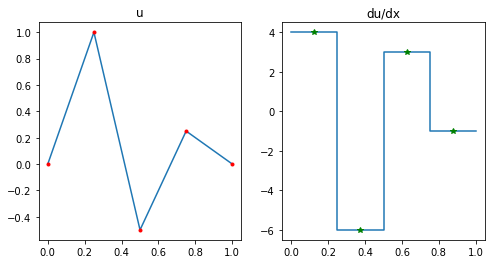

In [2]:
nodes = np.linspace(0.0, 1.0, 5)
u_at_nodes = np.array([0.0, 1.0, -0.5, 0.25, 0.0])

cell_centers = 0.5 * (nodes[1:] + nodes[:-1])
du_dx_in_cells = np.array([4., -6., 3., -1.])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(nodes, u_at_nodes)
plt.plot(nodes, u_at_nodes, '.r')
plt.title('u')

plt.subplot(1, 2, 2)
plt.plot(nodes, np.concatenate([du_dx_in_cells, [-1]]), drawstyle='steps-post')
plt.plot(cell_centers, du_dx_in_cells, '*g')
plt.title('du/dx')

### Your task:
Write a function called "spatial\_derivative" that takes the length-$(N+2)$ vector of nodal values for $u$ as input, and returns the length-$N+1$ vector of cell values of $\frac{du}{dx}$ as output.

In [3]:
def spatial_derivative(u_at_nodes):
    N = len(u_at_nodes) - 2
    h = 1 / (N + 1)
    du_dx_in_cells = (u_at_nodes[1:] - u_at_nodes[:-1]) / h
    return du_dx_in_cells

### Test:
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [4]:
u = np.array([0.25, -0.66, 0.70, -0.41, -1.02, 0.57, 0.13, -1.27, 0.83, -1.21])
du_dx_true = np.array([-8.19, 12.24, -9.99, -5.49, 14.31, -3.96, -12.6, 18.9, -18.36])

du_dx = spatial_derivative(u)
spatial_derivative_error = np.linalg.norm(du_dx - du_dx_true)
print('spatial_derivative_error=', spatial_derivative_error)

spatial_derivative_error= 5.7044291861996796e-15


## 2b) Arc length function

In Problem 1 you showed that the arc length of a function $u:[0,1]\rightarrow \mathbb{R}$ is given by
$$L(u) = \int_0^1 \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx$$

### Your task:
Let $u$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes, including endpoints (the same setup as in 2a). Write a function called "length\_functional" that takes the vector of $N+2$ nodal values of $u$ as input, and returns the arc length of $u$ as output.

#### Hint:
The integrand is a piecewise constant function.

In [5]:
def length_functional(u_at_nodes):
    N = len(u_at_nodes) - 2
    h = 1 / (N + 1)
    du_dx_in_cells = spatial_derivative(u_at_nodes)
    L = h * np.sqrt(1 + du_dx_in_cells ** 2).sum()
    return L

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [6]:
xx = np.linspace(0.0, 1.0, 100)
u = np.sqrt(1.0 / 2.0 - np.power(xx - 0.5, 2))
L_true = 1.1107087105088733

L = length_functional(u)
length_functional_error = np.abs(L - L_true)
print('length_functional_error=', length_functional_error)

length_functional_error= 0.0


## 2c) Energy functional

Let $u$ be the height of an idealized hanging chain, and for convenience let the linear density of the chain be $\rho=1/g$, where the $g$ is the gravitational constant. From Problem 1 we know that the potential energy functional for such a hanging chain is given by
$$E(u) = \int_0^1 u(x) \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx.$$

### Your task
Write a function named "energy\_functional" that takes as input the length $N+2$ vector of nodal values for a continuous piecewise linear function $u$ on $[0,1]$ as input (including values at the endpoints, as in 2a and 2b), and returns the energy functional $E(u)$ as output.

#### Hint:
The integrand is a **discontinuous** piecewise linear function because it is the product of a continuous piecewise linear function with a piecewise constant function.

In [7]:
def energy_functional(u_at_nodes):
    N = len(u_at_nodes) - 2
    h = 1 / (N + 1)
    u_mid = (u_at_nodes[1:] + u_at_nodes[:-1]) / 2
    du_dx_in_cells = spatial_derivative(u_at_nodes)
    E = h * (u_mid * np.sqrt(du_dx_in_cells ** 2 + 1)).sum()
    return E

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [8]:
xx = np.linspace(0.0, 1.0, 75)
u = -np.sin(np.pi * xx)
E_true = -1.2379425688273515

E = energy_functional(u)
energy_functional_error = np.abs(E - E_true)
print('energy_functional_error=', energy_functional_error)

energy_functional_error= 0.0


# 3)  Objective function, Gradient, and Hessian

In problem 1 we saw that the hanging chain problem may be written as the following constrained optimization problem:

\begin{align}
\min_u &\quad E(u) \\
\text{such that} &\quad L(u) = L_0.
\end{align}

We may find approximate solutions to this problem by solving the following unconstrained optimization problem,
$$\min_u E(u) + \alpha (L(u) - L_0)^2$$
where we use a quadratic penalty to approximately enforce the constraint. Here $\alpha > 0$ is a penalty parameter; as $\alpha \rightarrow \infty$, the solution to the unconstrained optimization problem approaches the solution of the constrained optimization problem.

Let
$$J(u) := E(u) + \alpha (L(u) - L_0)^2$$
denote the unconstrained objective function. In this problem, you will implement this objective function for continuous piecewise linear functions with equally spaced nodes, and use **automatic differentiation** to compute the gradient of $J$, the Hessian of $J$, and matrix-vector products of the Hessian of $J$ with arbitrary vectors. You will also compare the gradient and Hessian of $J$ to approximate gradients and Hessians computed with finite differences with a variety of step sizes.

## Objective function
The objective function may be written as follows, using your energy and length functional code from the previous problem. Note that the objective function only operates on the $N$ interior nodes for $u$, since the endpoints of $u$ are fixed at zero.

In [9]:
def objective_function(u_at_interior_nodes, alpha, L0):
    u_at_nodes = np.hstack([np.array([0.0]),
                            u_at_interior_nodes,
                            np.array([0.0])])

    E = energy_functional(u_at_nodes)
    L = length_functional(u_at_nodes)
    J = E + alpha * np.power(L - L0, 2)
    return J

If you were unable to complete the previous problem, you may uncomment the following (intentionally obfsucated) implementation and use it instead:

In [10]:
# def objective_function(u_at_interior_vertices, alpha, L0):
#     u = np.concatenate([np.array([0]),
#                         u_at_interior_vertices,
#                         np.array([0])])
#     a = 1./(len(u)-1.)
#     b, c = (u[1:]-u[:-1])/a, 0.5*(u[1:] + u[:-1])
#     return a*np.sum(c*np.sqrt(1.+np.power(b,2)))+alpha*np.power(a*np.sum(np.sqrt(1.+np.power(b,2)))-L0,2)

## 3a) Gradient via automatic differentiation

Here we will use the "grad" function in the python automatic differentiation tool **autograd** to compute the gradient of your objective function. Here is a quick example of how to use it. More details can be found here:
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md

### autodiff grad example

In [11]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])


grad_autodiff = grad(f, 0)  # 0 indicates differentiation w.r.t. the first argument of f.

x = np.random.randn(2)
a = 1.3
b = -2.1
grad_at_x_autodiff = grad_autodiff(x, a, b)

grad_at_x_analytic = np.array([- a * np.sin(a * x[0]),
                               b * np.cos(b * x[1])])

autodiff_error = np.linalg.norm(grad_at_x_analytic - grad_at_x_autodiff)
print('autodiff_error=', autodiff_error)

autodiff_error= 0.0


### Your task:
Use automatic differentiation to create a function named "compute\_gradient" that computes the gradient of the objective function, $g$, at a given $u$ for a given penalty parameter $\alpha$ and chain length $L_0$.

### Hint:
The code is a one-liner

In [12]:
# Construct the function compute_gradient(u_at_interior_nodes, alpha, L0)
def compute_gradient(u_at_interior_nodes, alpha, L0):
    return grad(objective_function, 0)(u_at_interior_nodes, alpha, L0)

### Finite difference check:
On one hand, the directional derivative of $J$ in direction $p$ may be computed from the gradient at $u$, $g(u)$, as follows:
$$\frac{d J}{d u}(u) p = g(u)^T p.$$
On the other hand, we may approximate the directional derivative via finite differences
$$\frac{d J}{du}(u) p \approx \frac{J(u + s p) - J(u)}{s}$$
where $s$ is some small scalar.

This allows us to check our gradient by choosing a random direction $p$, and comparing the result of computing $\frac{d J}{d u}(u) p$ in these two different ways. 

The error should be roughly the same order of magnitude as the step size.

In [13]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
J1 = objective_function(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7  # step size
u2 = u1 + s * p

J2 = objective_function(u2, alpha, L0)
dJ_du_p_diff = (J2 - J1) / s

g = compute_gradient(u1, alpha, L0)
dJ_du_p = np.dot(g, p)

grad_err = np.abs((dJ_du_p - dJ_du_p_diff) / dJ_du_p_diff)
print('step size=', s, ', gradient finite difference error=', grad_err)

step size= 1e-07 , gradient finite difference error= 6.593787950678388e-07


## 3b) Gradient finite difference plot

It is good practice to check your gradient with finite difference checks for a wide range of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. If your gradient is working correctly, the resulting plot should look like a 'V', where the error decreases linearly from $s=10^0$ until somewhere around $s=10^{-5}$ to $s=10^{-9}$, then goes up again and/or becomes jagged.

### Example finite difference plot

step size= 1.0 , example gradient finite difference error= 4.350528738457639
step size= 0.1 , example gradient finite difference error= 0.13156229707598632
step size= 0.01 , example gradient finite difference error= 0.011479637013086253
step size= 0.001 , example gradient finite difference error= 0.0011333175842981188
step size= 0.0001 , example gradient finite difference error= 0.00011318714149722931
step size= 1e-05 , example gradient finite difference error= 1.131727907205764e-05
step size= 1e-06 , example gradient finite difference error= 1.1315408097496606e-06
step size= 1e-07 , example gradient finite difference error= 1.1252218669450234e-07
step size= 1e-08 , example gradient finite difference error= 1.1693150615754554e-08
step size= 1e-09 , example gradient finite difference error= 1.0891453985561664e-08
step size= 1e-10 , example gradient finite difference error= 1.1183375208907357e-06
step size= 1e-11 , example gradient finite difference error= 1.1183375210036585e-06
step siz

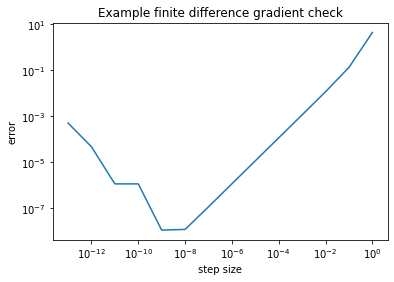

In [14]:
def f(x):
    return np.sin(x[0]) + np.cos(x[1])


def df_dx(x):
    return np.array([np.cos(x[0]), -np.sin(x[1])])


x1 = np.random.randn(2)
p = np.random.randn(2)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

f1 = f(x1)
g1 = df_dx(x1)
df_dx_p = np.dot(g1, p)

grad_errs = list()
for s in step_sizes:
    x2 = x1 + s * p

    f2 = f(x2)
    df_dx_p_diff = (f2 - f1) / s

    grad_err = np.abs((df_dx_p - df_dx_p_diff) / df_dx_p_diff)
    print('step size=', s, ', example gradient finite difference error=', grad_err)

    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

plt.savefig('3b.eps')

### Your task:
Perform finite difference checks on the hanging chain gradient for a wide range  of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. See 3a for an example of a finite difference check for a single step size.

step size= 1.0 , example gradient finite difference error= 0.5707562564993071
step size= 0.1 , example gradient finite difference error= 0.07288233458779578
step size= 0.01 , example gradient finite difference error= 0.008469629437084736
step size= 0.001 , example gradient finite difference error= 0.0009113412780260756
step size= 0.0001 , example gradient finite difference error= 9.1758500536369e-05
step size= 1e-05 , example gradient finite difference error= 9.182088461860178e-06
step size= 1e-06 , example gradient finite difference error= 9.178001138174299e-07
step size= 1e-07 , example gradient finite difference error= 1.0124809506321934e-07
step size= 1e-08 , example gradient finite difference error= 7.890965572361597e-08
step size= 1e-09 , example gradient finite difference error= 1.888923826637634e-07
step size= 1e-10 , example gradient finite difference error= 2.1365392570212684e-06
step size= 1e-11 , example gradient finite difference error= 5.1426514321086844e-05
step size= 1e

Text(0, 0.5, 'error')

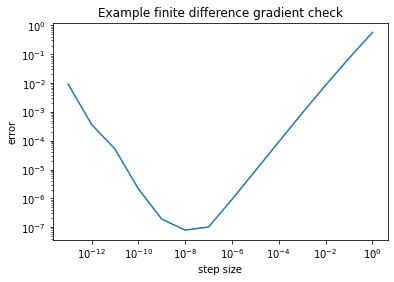

In [15]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

# Make log-log plot of gradient finite difference error vs. step size

J1 = objective_function(u1, alpha, L0)
dJ1 = compute_gradient(u1, alpha, L0)
dJ_dx_p = np.dot(dJ1, p)

grad_errs = list()
for s in step_sizes:
    u2 = u1 + s * p

    J2 = objective_function(u2, alpha, L0)
    dJ_dx_p_diff = (J2 - J1) / s

    grad_err = np.abs((dJ_dx_p - dJ_dx_p_diff) / dJ_dx_p_diff)
    print('step size=', s, ', example gradient finite difference error=', grad_err)

    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

## 3c) Hessian-vector product via automatic differentiation

The Hessian is the derivative of the gradient, so the matrix-vector multiplication $H(u)p$ of the Hessian at $u$, $H(u)$, with a vector, $p$ is given by
$$H(u)p = \frac{d}{du} \left(\frac{d J}{du}(u) p\right) = \frac{d}{du} \left(g(u)^T p\right).$$
In other words, $H(u) p$ is the gradient of the scalar-valued function
$$q(u) := g(u)^T p,$$
and this gradient may be calculated by automatic differentiation.

### Example:

In [16]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])


compute_grad_f = grad(f, 0)


def q(x, p, a, b):
    g = compute_grad_f(x, a, b)
    return np.dot(g, p)


hessian_vector_product_f = grad(q, 0)

a = 1.4
b = 4.1
x = np.random.randn(2)
p = np.random.randn(2)

Hp_autodiff = hessian_vector_product_f(x, p, a, b)

H_analytic = np.array([[-a * a * np.cos(a * x[0]), 0],
                       [0, -b * b * np.sin(b * x[1])]])

Hp_analytic = np.dot(H_analytic, p)

hess_prod_err = np.linalg.norm(Hp_analytic - Hp_autodiff) / np.linalg.norm(Hp_analytic)
print('example hessian vector product error=', hess_prod_err)

example hessian vector product error= 0.0


### Your task:
Use autodiff's grad function to create a function named "compute\_hessian\_vector\_product" that computes the Hessian-vector product $H(u)p$.

In [17]:
# Construct the function compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)
def q(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    return np.dot(compute_gradient(u_at_interior_nodes, alpha, L0), p_at_interior_nodes)


def compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    return grad(q, 0)(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)

### Finite difference check
The error should be roughly the same order of magnitude as the step size.

In [18]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
G1 = compute_gradient(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7
u2 = u1 + s * p
G2 = compute_gradient(u2, alpha, L0)

Hp_diff = (G2 - G1) / s

Hp = compute_hessian_vector_product(u1, p, alpha, L0)

hessian_vector_product_error = np.linalg.norm(Hp - Hp_diff) / np.linalg.norm(Hp_diff)

print('s=', s, ', hessian vector product finite difference error=', hessian_vector_product_error)

s= 1e-07 , hessian vector product finite difference error= 2.5322977683122755e-06


## 3d) Hessian-vector product finite difference check plot

### Your task:
Construct a log-log plot of the Hessian finite difference error for a wide range of step sizes.

step size= 1.0 , example gradient finite difference error= 1.360461458225647
step size= 0.1 , example gradient finite difference error= 0.5589131109372201
step size= 0.01 , example gradient finite difference error= 0.004778975677738115
step size= 0.001 , example gradient finite difference error= 0.01030827315627457
step size= 0.0001 , example gradient finite difference error= 0.0011947002153393025
step size= 1e-05 , example gradient finite difference error= 0.00012107855352274788
step size= 1e-06 , example gradient finite difference error= 1.2123885590282163e-05
step size= 1e-07 , example gradient finite difference error= 1.2124253919879889e-06
step size= 1e-08 , example gradient finite difference error= 1.2330412539529774e-07
step size= 1e-09 , example gradient finite difference error= 1.951235130464611e-09
step size= 1e-10 , example gradient finite difference error= 1.82888931645145e-08
step size= 1e-11 , example gradient finite difference error= 1.3431807783140759e-06
step size= 1e-

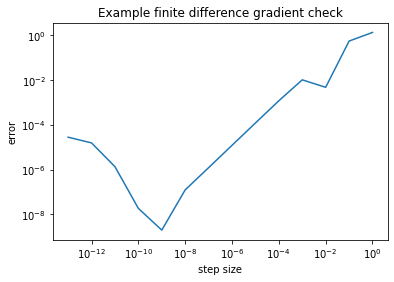

In [19]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

# Make log-log plot of gradient finite difference error vs. step size

q1 = q(u1, p, alpha, L0)
dq1 = compute_hessian_vector_product(u1, p, alpha, L0)
dq_dx_p = np.dot(dq1, p)

grad_errs = list()
for s in step_sizes:
    u2 = u1 + s * p

    q2 = q(u2, p, alpha, L0)
    dq_dx_p_diff = (q2 - q1) / s

    grad_err = np.abs((dq_dx_p - dq_dx_p_diff) / dq_dx_p_diff)
    print('step size=', s, ', example gradient finite difference error=', grad_err)

    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

plt.savefig('3d.eps')

### Comparison with dense Hessian

The  $N \times N$ Hessian matrix is the Jacobian of the gradient, which can also be computed via automatic differentiation. This is not recommended for large problems.

Here we show how to compute the  Hessian using the Jacobian function in autograd.

In [20]:
compute_hessian = jacobian(compute_gradient, 0)

### Test dense Hessian
Error should be of the order machine epsilon (less than $10^{-14}$)

In [21]:
N = 15
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)

H = compute_hessian(u1, alpha, L0)

p = np.random.randn(N)
Hp_dense = np.dot(H, p)
Hp = compute_hessian_vector_product(u1, p, alpha, L0)

dense_hessian_error = np.linalg.norm(Hp_dense - Hp) / np.linalg.norm(Hp)
print('dense_hessian_error=', dense_hessian_error)

dense_hessian_error= 1.6657663271983265e-15


# 4) Comparison of optimization methods

In this problem, we will minimize $J$ using the method of steepest descent, BFGS, and the Newton-Conjugate-Gradient method. We will also plot convergence curves, and estimate the rate of convergence for these methods.

We will show you how to do this using BFGS as an example, and you will do this for steepest descent and Newton-CG.

### Problem parameters

For this problem, please use $N=32$, $L_0 = 3.0$, and $\alpha=1e2$.

In [22]:
N = 32
L0 = 3.0
alpha = 1e2

# Useful versions of the objective, gradient, 
# and hessian-vector product functions
J_func = lambda u: objective_function(u, alpha, L0)
g_func = lambda u: compute_gradient(u, alpha, L0)
Hp_func = lambda u, p: compute_hessian_vector_product(u, p, alpha, L0)

### Initial guess

A reasonable initial guess is the parabola
$$u_0(x) = -C x(1-x)$$
with constant 
$$C = 2 \left(L_0 - 1\right).$$
The constant $C$ is chosen to make the arc length of $u$ close to $L_0$. The formula for $C$ can be derived by the sum of the lengths of the left, right, and bottom edges of the box that bounds the parabola.

In [23]:
xx_including_endpoints = np.linspace(0.0, 1.0, N + 2)

C = -2.0 * (L0 - 1.0)
u0_including_endpoints = C * xx_including_endpoints * (1.0 - xx_including_endpoints)
u0 = u0_including_endpoints[1:-1]

### Example: BFGS

In [24]:
u = u0.copy()
JJ_bfgs = list()


def callback(uk):
    JJ_bfgs.append(J_func(uk))


sol = optimize.minimize(J_func, u0, method='BFGS', jac=g_func, callback=callback, tol=1e-6)
print(sol)

u = sol.x

      fun: -2.1828846090865994
 hess_inv: array([[ 6.57492324,  5.84133882,  4.90921983, ..., -0.88158642,
        -0.09717394,  0.1817861 ],
       [ 5.84133882,  8.82914747,  7.50242151, ..., -1.48517034,
        -0.77003233, -0.46416864],
       [ 4.90921983,  7.50242151,  8.78826227, ..., -1.71815453,
        -1.08054079, -1.09690032],
       ...,
       [-0.88158642, -1.48517034, -1.71815453, ...,  8.99515429,
         7.55303007,  4.42218174],
       [-0.09717394, -0.77003233, -1.08054079, ...,  7.55303007,
         9.01402474,  5.6927937 ],
       [ 0.1817861 , -0.46416864, -1.09690032, ...,  4.42218174,
         5.6927937 ,  6.01818753]])
      jac: array([ 5.27448952e-08, -8.63670838e-08,  7.38221981e-09, -7.08360714e-08,
        4.05469949e-08,  1.87908797e-08,  5.02561790e-08,  6.30910647e-08,
       -3.66293389e-07,  1.42442041e-07,  9.44833630e-07, -7.74426742e-07,
       -7.61117371e-07,  7.10293948e-07, -7.73070396e-07,  6.96737724e-08,
        4.12449865e-08,  2.1268658

### BFGS: check that solution gradient is small and plot the solution

||g(u)|| / ||g(u_0)||= 3.2362484898429905e-08


Text(0, 0.5, 'u(x)')

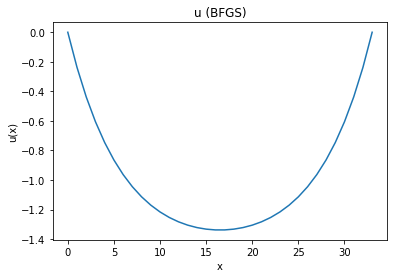

In [25]:
norm_g0 = np.linalg.norm(g_func(u0))
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0)  # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (BFGS)')
plt.xlabel('x')
plt.ylabel('u(x)')

### BFGS: Make a convergence plot and estimate convergence rate

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

We can estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. We use the final value of $J$ as the solution $J(u_*)$. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The convergence order is estimated to be 1.03


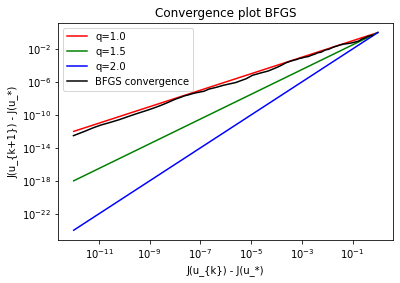

In [26]:
def loglog_convergence_order(JJ, method):
    log_lower_limit = int(np.log10(np.min(JJ[:-1] - JJ[-1])))
    log_upper_limit = min(0, int(np.log10(np.max(JJ[:-1] - JJ[-1]))))
    kk = np.logspace(log_lower_limit, log_upper_limit, log_upper_limit - log_lower_limit + 1)
    yy10 = np.power(kk, 1.0)
    yy15 = np.power(kk, 1.5)
    yy20 = np.power(kk, 2.0)
    plt.loglog(kk, yy10, 'r')
    plt.loglog(kk, yy15, 'g')
    plt.loglog(kk, yy20, 'b')

    plt.loglog(JJ[:-2] - JJ[-1], JJ[1:-1] - JJ[-1], 'k')
    plt.title(f'Convergence plot {method}')
    plt.ylabel('J(u_{k+1}) - J(u_*)')
    plt.xlabel('J(u_{k}) - J(u_*)')
    plt.legend(['q=1.0', 'q=1.5', 'q=2.0', f'{method} convergence'])

    # Perform a linear regression on the log difference log(J-J*)
    x = JJ[:-2] - JJ[-1]
    aug_x = np.vstack([x, np.ones(len(x))]).T
    y = JJ[1:-1] - JJ[-1]
    q, c = np.linalg.lstsq(np.log(aug_x), np.log(y), rcond=None)[0]
    print(f'The convergence order is estimated to be {q:.2f}')
    plt.savefig(f'4{method}.eps')


loglog_convergence_order(JJ_bfgs, 'BFGS')

## 4a) Steepest descent

The method of steepest descent minimizes the function $J(u)$ via the iteration
$$u_{k+1} = u_k - \beta
_kg(u_k)$$
where $u_k$ is the $k\text{th}$ iterate, $g(u_k)$ is the gradient at the $k\text{th}$ iterate, and $\beta_k$ is a step size parameter.

### Your task:

Minimize $J$ using the method of steepest descent. You should write your own steepest descent code for this (do not use existing steepest descent libraries).

Continue iterating until $||g_k|| < 10^{-6} ||g_0||$ or smaller. This should require several thousand iterations.

Save the function values $J(u_k)$ for all iterations so we can plot the convergence.


#### Hint: step size

The trick here is choosing $\beta_k$. If $\beta_k$ is too large, the method may become unstable and diverge. If $\beta_k$ is too small, the method will converge slowly. 

A popular option is to choose a step length satisfying the Wolfe conditions:

https://en.wikipedia.org/wiki/Wolfe_conditions

You may use the function scipy.optimize.line_search to find a step length satisfying these conditions:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html#scipy.optimize.line_search

In [27]:
u = u0.copy()  # update u each iteration

J0 = J_func(u)
g0 = g_func(u)
norm_g0 = np.linalg.norm(g0)

JJ_sd = list()
JJ_sd.append(J0)  # Keep appending the value of J to this list each iteration

# Solve optimization problem using method of steepest descent.
g = g0
while True:
    g = g_func(u)
    if np.linalg.norm(g) < 10 ** (-6) * norm_g0:
        break
    step_size, _, _, J_new, _, _ = optimize.line_search(J_func, g_func, u, -g)
    u -= step_size * g
    JJ_sd.append(J_new)

# Now the solution should be in the variable u
# and JJ_sd should be a list, with JJ[k] = J(u_k)

JJ_sd = np.array(JJ_sd)  # Make JJ_sd into array instead of list

### Test:

||g(u)|| / ||g(u_0)||= 9.947168732070596e-07


Text(0, 0.5, 'u(x)')

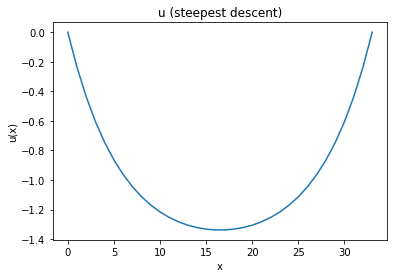

In [28]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0)  # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (steepest descent)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4b) Steepest descent convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

The convergence order is estimated to be 1.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


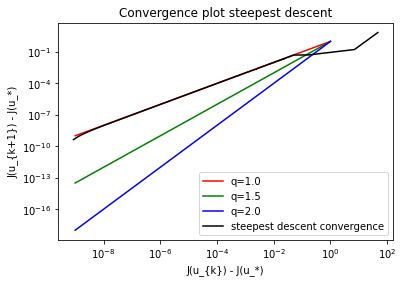

In [29]:
# Make a log-log convergence plot for steepest descent and estimate the convergence rate

loglog_convergence_order(JJ_sd, 'steepest descent')

## 4c) Newton-CG

### Your task:

Minimize $J$ using the Newton-CG method implemented in scipy.optimize.minimize:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html

 - Use a tolerance of $10^{-6}$

 - Save the intermediate values of $J(u_k)$ so that we can study convergence.


### Hint:
To save intermediate values of $J(u_k)$, use a "callback" function.

In [30]:
u = u0.copy()
JJ_ncg = list()


def callback(uk):
    JJ_ncg.append(J_func(uk))


sol = optimize.minimize(J_func, u, jac=g_func, method='Newton-CG',
                        hessp=Hp_func, callback=callback, tol=1e-6)
print(sol)

u = sol.x

     fun: -2.182884609087087
     jac: array([-5.40412008e-09, -3.78689014e-08,  1.49981752e-08, -3.85935663e-08,
       -4.11020109e-08, -8.76084377e-08, -8.94155245e-08, -1.22422987e-07,
       -1.79908486e-07, -2.46142319e-07, -3.20290507e-07, -4.16410985e-07,
       -4.78102499e-07, -6.12885056e-07, -6.38369353e-07, -6.97930519e-07,
       -7.17164686e-07, -6.50375249e-07, -5.89092698e-07, -5.07022375e-07,
       -4.02267994e-07, -3.18186320e-07, -2.39660794e-07, -1.77900922e-07,
       -1.35334266e-07, -9.88515605e-08, -7.57521455e-08, -7.20995581e-08,
       -3.93216695e-08, -9.88454468e-09, -5.34302160e-08, -1.85196441e-08])
 message: 'Optimization terminated successfully.'
    nfev: 37
    nhev: 259
     nit: 27
    njev: 37
  status: 0
 success: True
       x: array([-0.23795173, -0.4378941 , -0.60578279, -0.74661865, -0.86459672,
       -0.96323118, -1.04546002, -1.11373258, -1.17008248, -1.21618818,
       -1.25342302, -1.28289612, -1.30548537, -1.32186363, -1.33251877,
    

### Test

||g(u)|| / ||g(u_0)||= 2.1850970015394895e-10


Text(0, 0.5, 'u(x)')

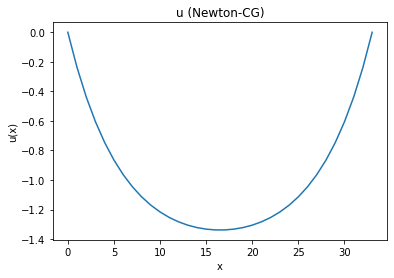

In [31]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0)  # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (Newton-CG)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4d) Newton-CG convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, for Newton-CG by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and estimating the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The convergence order is estimated to be 1.24


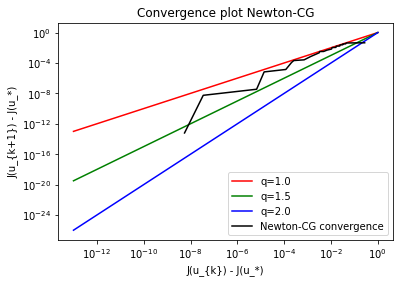

In [32]:
# Make a log-log convergence plot for Newton-CG and estimate the convergence rate
# For the estimation, see the definition of the `loglog_convergence_order` function.
loglog_convergence_order(JJ_ncg, 'Newton-CG')

## 5a) SD does not exhibit mesh independence

In [119]:
# Restate the problem

L0 = 3.0
alpha = 1e2

J_func = lambda u: objective_function(u, alpha, L0)
g_func = lambda u: compute_gradient(u, alpha, L0)
Hp_func = lambda u, p: compute_hessian_vector_product(u, p, alpha, L0)


def sd_solver(N, tol=1e-6, maxiter=1e4):
    xx_including_endpoints = np.linspace(0.0, 1.0, N + 2)

    C = -2.0 * (L0 - 1.0)
    u0_including_endpoints = C * xx_including_endpoints * (1.0 - xx_including_endpoints)
    u0 = u0_including_endpoints[1:-1]

    u = u0.copy()  # update u each iteration

    J0 = J_func(u)
    g0 = g_func(u)
    norm_g0 = np.linalg.norm(g0)
    JJ_sd = [J0]
    uu_sd = [u]

    # Solve optimization problem using method of steepest descent.
    g = g0
    for _ in range(int(maxiter)):
        g = g_func(u)
        if np.linalg.norm(g) < tol * norm_g0:
            break
        step_size, _, _, J_new, _, _ = optimize.line_search(J_func, g_func, u, -g)
        u -= step_size * g
        JJ_sd.append(J_new)
        uu_sd.append(u)

    JJ_sd = np.array(JJ_sd)  # Make JJ_sd into array instead of list

    return JJ_sd, uu_sd


def ncg_solver(N, tol=1e-6):
    xx_including_endpoints = np.linspace(0.0, 1.0, N + 2)

    C = -2.0 * (L0 - 1.0)
    u0_including_endpoints = C * xx_including_endpoints * (1.0 - xx_including_endpoints)
    u0 = u0_including_endpoints[1:-1]

    u = u0.copy()
    JJ_ncg = []
    uu_ncg = []
    LL_ncg = []

    def callback(uk):
        JJ_ncg.append(J_func(uk))
        uu_ncg.append(uk)
        LL_ncg.append(length_functional(uk))

    sol = optimize.minimize(J_func, u, jac=g_func, method='Newton-CG',
                            hessp=Hp_func, callback=callback, tol=tol,
                            options={'disp': False})
    print(sol)

    return JJ_ncg, uu_ncg, LL_ncg


JJ_ncg_fine_small_tor, _, _ = ncg_solver(255, tol=1e-8)

     fun: -2.1830984599717502
     jac: array([ 2.96229534e-11,  9.57051569e-09,  5.22357786e-09, -3.38358047e-09,
        1.44657594e-09, -2.17081344e-09,  2.73486597e-09, -7.52582463e-10,
       -3.31370068e-09, -6.68521436e-09, -3.62947032e-09,  1.68534492e-10,
        1.01982184e-08, -3.41529812e-09,  2.40790886e-09,  5.90057978e-09,
        2.13524888e-09, -1.92762950e-09,  7.00626987e-10, -1.92681662e-09,
        1.41880032e-09, -6.38024693e-09, -1.22871976e-10, -6.51762592e-09,
        6.82493468e-09, -7.07982777e-09,  2.99248358e-09, -2.65439407e-09,
       -2.32953118e-09,  4.85028863e-09,  2.29355712e-09,  9.18797295e-11,
        1.25551860e-08, -9.98587624e-10,  3.26909862e-09, -2.30575645e-09,
        3.54403006e-09,  8.51148570e-10, -6.77184604e-09, -5.18769403e-09,
       -1.86264926e-09, -3.91031939e-10, -1.67903516e-09,  4.78152017e-09,
       -4.44552251e-09, -5.63253666e-09,  6.85449797e-09,  4.57540653e-10,
       -2.58785849e-09,  5.94324583e-10, -2.74329350e-09, -6

100%|██████████| 4/4 [00:57<00:00, 14.35s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


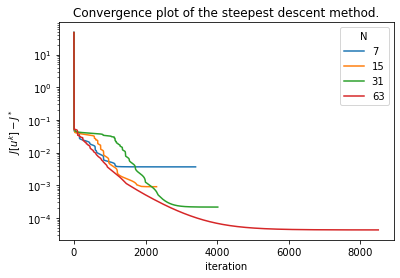

In [90]:
plt.figure()
plt.grid('on')
Ns = 2 ** np.arange(3, 8) - 1

for N in tqdm(Ns):
    JJ_sd, uu_sd = sd_solver(N)
    plt.plot(range(len(JJ_sd)), JJ_sd - JJ_ncg_fine_small_tor[-1], label=f'{N}')
plt.gca().set(
    xlabel='iteration',
    ylabel='$J[u^k]-J^*$',
    yscale='log',
)
plt.title('Convergence plot of the steepest descent method.')
plt.legend(title='N')
plt.savefig('5a.eps')

## 5b) Newton-CG has some mesh independence

 20%|██        | 1/5 [00:00<00:00,  5.58it/s]

     fun: -2.1794115136702947
     jac: array([-4.93882232e-07, -9.44053620e-07, -2.45887905e-06, -3.80854030e-06,
       -2.45887934e-06, -9.44053477e-07, -4.93882247e-07])
 message: 'Optimization terminated successfully.'
    nfev: 29
    nhev: 53
     nit: 22
    njev: 29
  status: 0
 success: True
       x: array([-0.76829501, -1.1348368 , -1.29726426, -1.34315811, -1.29726426,
       -1.1348368 , -0.76829501])


 40%|████      | 2/5 [00:00<00:00,  3.63it/s]

     fun: -2.1821774891248564
     jac: array([-1.24757796e-09,  1.56142538e-09, -4.79281859e-09, -4.25841945e-09,
       -5.69190400e-09, -1.01358727e-08, -1.52712322e-08, -1.80174315e-08,
       -1.66669678e-08, -1.26186716e-08, -8.08216303e-09, -3.40188004e-09,
        7.61287422e-10, -2.51659489e-09,  4.14452916e-11])
 message: 'Optimization terminated successfully.'
    nfev: 41
    nhev: 127
     nit: 30
    njev: 41
  status: 0
 success: True
       x: array([-0.45008769, -0.76369744, -0.98106365, -1.13007318, -1.22984314,
       -1.29317345, -1.32818905, -1.33938225, -1.32818905, -1.29317345,
       -1.22984314, -1.13007318, -0.98106364, -0.76369744, -0.45008768])


 60%|██████    | 3/5 [00:01<00:00,  2.20it/s]

     fun: -2.1828708075430723
     jac: array([-6.16074622e-10, -3.48203522e-10, -2.96590970e-09, -2.15276302e-09,
       -5.19141529e-09, -5.93493666e-09, -4.90151781e-09, -4.87700410e-09,
       -6.10206132e-09, -8.28177948e-09, -1.10542612e-08, -1.40356958e-08,
       -1.69324467e-08, -1.94243365e-08, -2.09085166e-08, -2.15118476e-08,
       -2.02378779e-08, -1.83325780e-08, -1.53201748e-08, -1.24353834e-08,
       -9.78256992e-09, -7.72905047e-09, -6.10430380e-09, -4.33446935e-09,
       -1.67403461e-09,  1.27927952e-09,  2.08645006e-09, -1.88970839e-10,
        1.63192550e-09, -1.07891805e-09, -7.31542271e-10])
 message: 'Optimization terminated successfully.'
    nfev: 35
    nhev: 250
     nit: 28
    njev: 35
  status: 0
 success: True
       x: array([-0.24475108, -0.44928587, -0.62008508, -0.76256051, -0.88122652,
       -0.97984306, -1.06153481, -1.1288902 , -1.18404339, -1.22874192,
       -1.26440206, -1.29215372, -1.31287621, -1.32722613, -1.33565814,
       -1.33843944, 

 80%|████████  | 4/5 [00:02<00:00,  1.13it/s]

     fun: -2.1830442499794938
     jac: array([ 4.30334118e-08,  1.57268344e-07,  3.92271739e-07,  5.08445954e-07,
       -8.72836981e-07, -6.75751815e-07,  2.04216916e-07,  2.99146350e-07,
        1.98392367e-07, -2.28299011e-07, -2.54578292e-07, -1.74395666e-07,
       -1.86365518e-07, -1.96623793e-07, -3.25792987e-07, -3.82692319e-07,
       -3.31238474e-07, -2.45789886e-07, -1.99056499e-07, -2.50738867e-07,
       -3.50579754e-07, -5.58608201e-07, -5.09344934e-07, -8.39063136e-07,
       -6.01860851e-07, -8.12188986e-07, -9.57348087e-07, -8.34617458e-07,
       -9.68791134e-07, -1.22324895e-06, -1.18825214e-06, -1.12384238e-06,
       -1.24944418e-06, -1.31712173e-06, -1.08001682e-06, -9.40916048e-07,
       -1.01280921e-06, -7.99100037e-07, -5.25046560e-07, -7.18543111e-07,
       -3.90687814e-07, -4.98797103e-07, -3.91482421e-07, -3.80087806e-07,
       -3.24962360e-07, -2.59660001e-07, -2.07612236e-07, -2.68051844e-07,
       -3.88147679e-07, -2.40893797e-07, -2.03074303e-07, -1

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]

     fun: -2.18308761762187
     jac: array([-3.58148532e-10, -1.19137200e-10,  6.25882731e-10, -4.18368382e-10,
       -1.28780216e-10,  2.48656588e-10,  4.50813067e-11, -2.66327824e-10,
       -1.59314884e-10, -1.22322940e-10,  5.97886046e-11, -9.44033046e-12,
        2.45129750e-11, -6.45421556e-10,  9.38328582e-12, -6.69957652e-10,
        1.56103602e-11, -1.23129278e-10,  1.85922448e-10, -8.17620797e-12,
        9.15780382e-10, -6.03698300e-10, -1.74338839e-10, -9.66802895e-10,
       -7.75336762e-10, -5.85674512e-11, -4.31164200e-10, -4.94113448e-10,
        3.16620433e-10,  6.87296045e-10,  2.95219566e-10, -9.56342054e-11,
        1.44944282e-10, -1.62700617e-11,  2.90187504e-10, -7.72695477e-10,
       -5.48246479e-10,  3.69394986e-10, -1.68056024e-09,  1.88436723e-09,
       -7.34705356e-10, -1.11360505e-09,  5.45477856e-10, -2.03463232e-10,
       -1.10926287e-09, -1.06239160e-10,  8.32943783e-10,  3.34278129e-10,
       -5.83771642e-10, -3.43826772e-10, -1.63217009e-11,  4.9

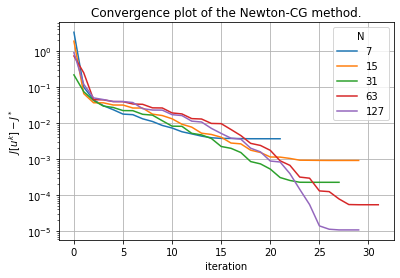

In [120]:
plt.figure()
plt.grid('on')
Ns = 2 ** np.arange(3, 8) - 1

for N in tqdm(Ns):
    JJ_ncg, uu_ncg, LL_ncg = ncg_solver(N)
    plt.plot(range(len(JJ_ncg)), JJ_ncg - JJ_ncg_fine_small_tor[-1], label=f'{N}')
plt.gca().set(
    xlabel='iteration',
    ylabel='$J[u^k]-J^*$',
    yscale='log',
)
plt.title('Convergence plot of the Newton-CG method.')
plt.legend(title='N')
# plt.savefig(f'5b-alpha-{alpha}.eps')

[2.8456386725874867, 2.9096357415127816, 2.9439180555071, 2.9368742135277373, 2.934988328891566, 2.9338623609714505, 2.932988254274608, 2.927909247236858, 2.9244856878113206, 2.9234585941266213]


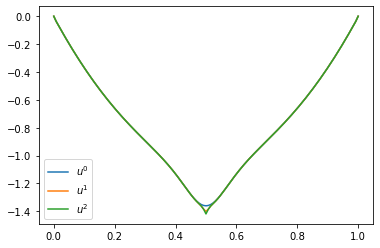

In [121]:
# Observe a cusp in the solutions that vanilla Newton-CG produce
plt.figure()
for i in 0, 1, 2:
    plt.plot(np.linspace(0, 1, len(uu_ncg[i])+2), np.hstack([0, uu_ncg[i], 0]), label=f'$u^{i}$')
plt.legend()
print(LL_ncg[:10])
# plt.savefig(f'5b-alpha-{alpha}-cusp.eps')